<p>
Prepared by Vytautas Bielinskas. 2020. <br>
Download data from: https://finance.yahoo.com/quote/GOOG/history/
</p>

<h2>PART 1. Data Pre-processing</h2>

<h3>Step #0. Fire the system</h3>

In [1]:
# Import modules and packages
import warnings

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime as dt
import dateutil.tz as tz
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

warnings.filterwarnings("ignore")
%matplotlib inline

<h3>Step #1. Read data</h3>

In [2]:
# Importing Training Set
dataset_train = pd.read_csv('data/jpm_bars_2024-03-06.csv')
dataset_train.rename(columns={'timestamp': 'date'}, inplace=True)
dataset_train['date'] = pd.to_datetime(dataset_train['date'])
dataset_train.tail()

,symbol,date,open,high,low,close,volume,trade_count,vwap
2051,JPM,2024-02-28 00:00:00-05:00,183.43,185.20,182.96,184.38,6131608.0,90914.0,184.413387
2052,JPM,2024-02-29 00:00:00-05:00,185.66,186.43,183.85,186.06,9642256.0,100032.0,185.571020
2053,JPM,2024-03-01 00:00:00-05:00,185.70,186.44,185.10,185.29,6311997.0,93783.0,185.490087
2054,JPM,2024-03-04 00:00:00-05:00,184.71,187.59,184.27,186.68,7062259.0,113106.0,186.647544
2055,JPM,2024-03-05 00:00:00-05:00,186.36,189.30,186.36,188.55,6618615.0,109782.0,188.315997


In [3]:
dataset_train.drop('symbol', axis=1, inplace=True)
dataset_train.set_index('date', inplace=True)
dataset_train.head()

,open,high,low,close,volume,trade_count,vwap
date,,,,,,,
2016-01-04 00:00:00-05:00,63.95,64.060,63.01,63.62,27827227.0,145804.0,63.451452
2016-01-05 00:00:00-05:00,63.69,64.130,63.04,63.73,17591872.0,103027.0,63.519312
2016-01-06 00:00:00-05:00,62.70,63.125,62.34,62.81,24407202.0,124497.0,62.745693
2016-01-07 00:00:00-05:00,61.46,62.000,60.08,60.27,29310297.0,166584.0,60.834008
2016-01-08 00:00:00-05:00,61.13,61.270,58.85,58.92,24651311.0,135242.0,59.791316


In [4]:
# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train.columns)

# Extract dates (will be used in visualization)
datelist_train = [idx.date() for idx in dataset_train.index]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (2056, 7)
All timestamps == 2056
Featured selected: ['open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap']


<h3>Step #2. Data pre-processing</h3>
<p>
Removing all commas and convert data to matrix shape format.
</p>

In [5]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.values

print('Shape of training set == {}.'.format(training_set.shape))
pd.DataFrame(training_set).head()

Shape of training set == (2056, 7).


,0,1,2,3,4,5,6
0,63.95,64.060,63.01,63.62,27827227.0,145804.0,63.451452
1,63.69,64.130,63.04,63.73,17591872.0,103027.0,63.519312
2,62.70,63.125,62.34,62.81,24407202.0,124497.0,62.745693
3,61.46,62.000,60.08,60.27,29310297.0,166584.0,60.834008
4,61.13,61.270,58.85,58.92,24651311.0,135242.0,59.791316


In [6]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
training_set = sc_predict.fit_transform(training_set[:, 0:1])
training_set.shape

(2056, 1)

In [7]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 60  # Number of days we want top predict into the future
n_past = 90  # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future + 1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (1907, 90, 6).
y_train shape == (1907, 1).


In [8]:
type(y_train)

numpy.ndarray

<h2>PART 2. Create a model. Training</h2>

<h3>Step #3. Building the LSTM based Neural Network</h3>

In [9]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1] - 1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

<h3>Step #4. Start training</h3>

In [10]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='.weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.5317
Epoch 1: val_loss improved from inf to 0.35560, saving model to .weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 0.5122 - val_loss: 0.3556 - learning_rate: 0.0100
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.2236
Epoch 2: val_loss improved from 0.35560 to 0.25523, saving model to .weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.2214 - val_loss: 0.2552 - learning_rate: 0.0100
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.1881
Epoch 3: val_loss did not improve from 0.25523
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.1890 - val_loss: 1.4312 - learning_rate: 0.0100
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1755
Epoch 4: val_loss did not improve from 0.25523
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.1760 - val_loss: 0.7411 - learning_rate: 0.0100
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.1592
Epoch 5: val_loss did not improve from 0.255

<p>
Notes:<br>
<ul>
<li><b>EarlyStopping</b> - Stop training when a monitored metric has stopped improving.</li>
<li><code>monitor</code> - quantity to be monitored.</li>
<li><code>min_delta</code> - minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than <code>min_delta</code>, will count as no improvement.</li>
<li><code>patience</code> - number of epochs with no improvement after which training will be stopped.</li>
</ul>

<ul>
<li><b>ReduceLROnPlateau</b> - Reduce learning rate when a metric has stopped improving.</li>
<li><code>factor</code> - factor by which the learning rate will be reduced. <code>new_lr = lr * factor</code>.</li>
</ul>
</p>

<hr>

<p>
The last date for our training set is <code>30-Dec-2016</code>.<br>
</p>

<p>
We will perform predictions for the next <b>20</b> days, since <b>2017-01-01</b> to <b>2017-01-20</b>.
</p>

<h2>PART 3. Make future predictions</h2>

In [11]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

<h3>Step #5. Make predictions for future dates</h3>

In [12]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [13]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['open']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['open']).set_index(pd.Series(datelist_train[2 * n_past + n_future - 1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)

,open
2016-12-13,76.266998
2016-12-14,76.380699
2016-12-15,76.397446


In [14]:
PREDICTION_TRAIN.tail(30)

,open
2024-01-23,158.981934
2024-01-24,159.147232
2024-01-25,158.236588
2024-01-26,158.559036
2024-01-29,158.688263
2024-01-30,158.849045
2024-01-31,159.059204
2024-02-01,159.250412
2024-02-02,159.569153
2024-02-05,159.961441


<h3>Step #6. Visualize the Predictions</h3>

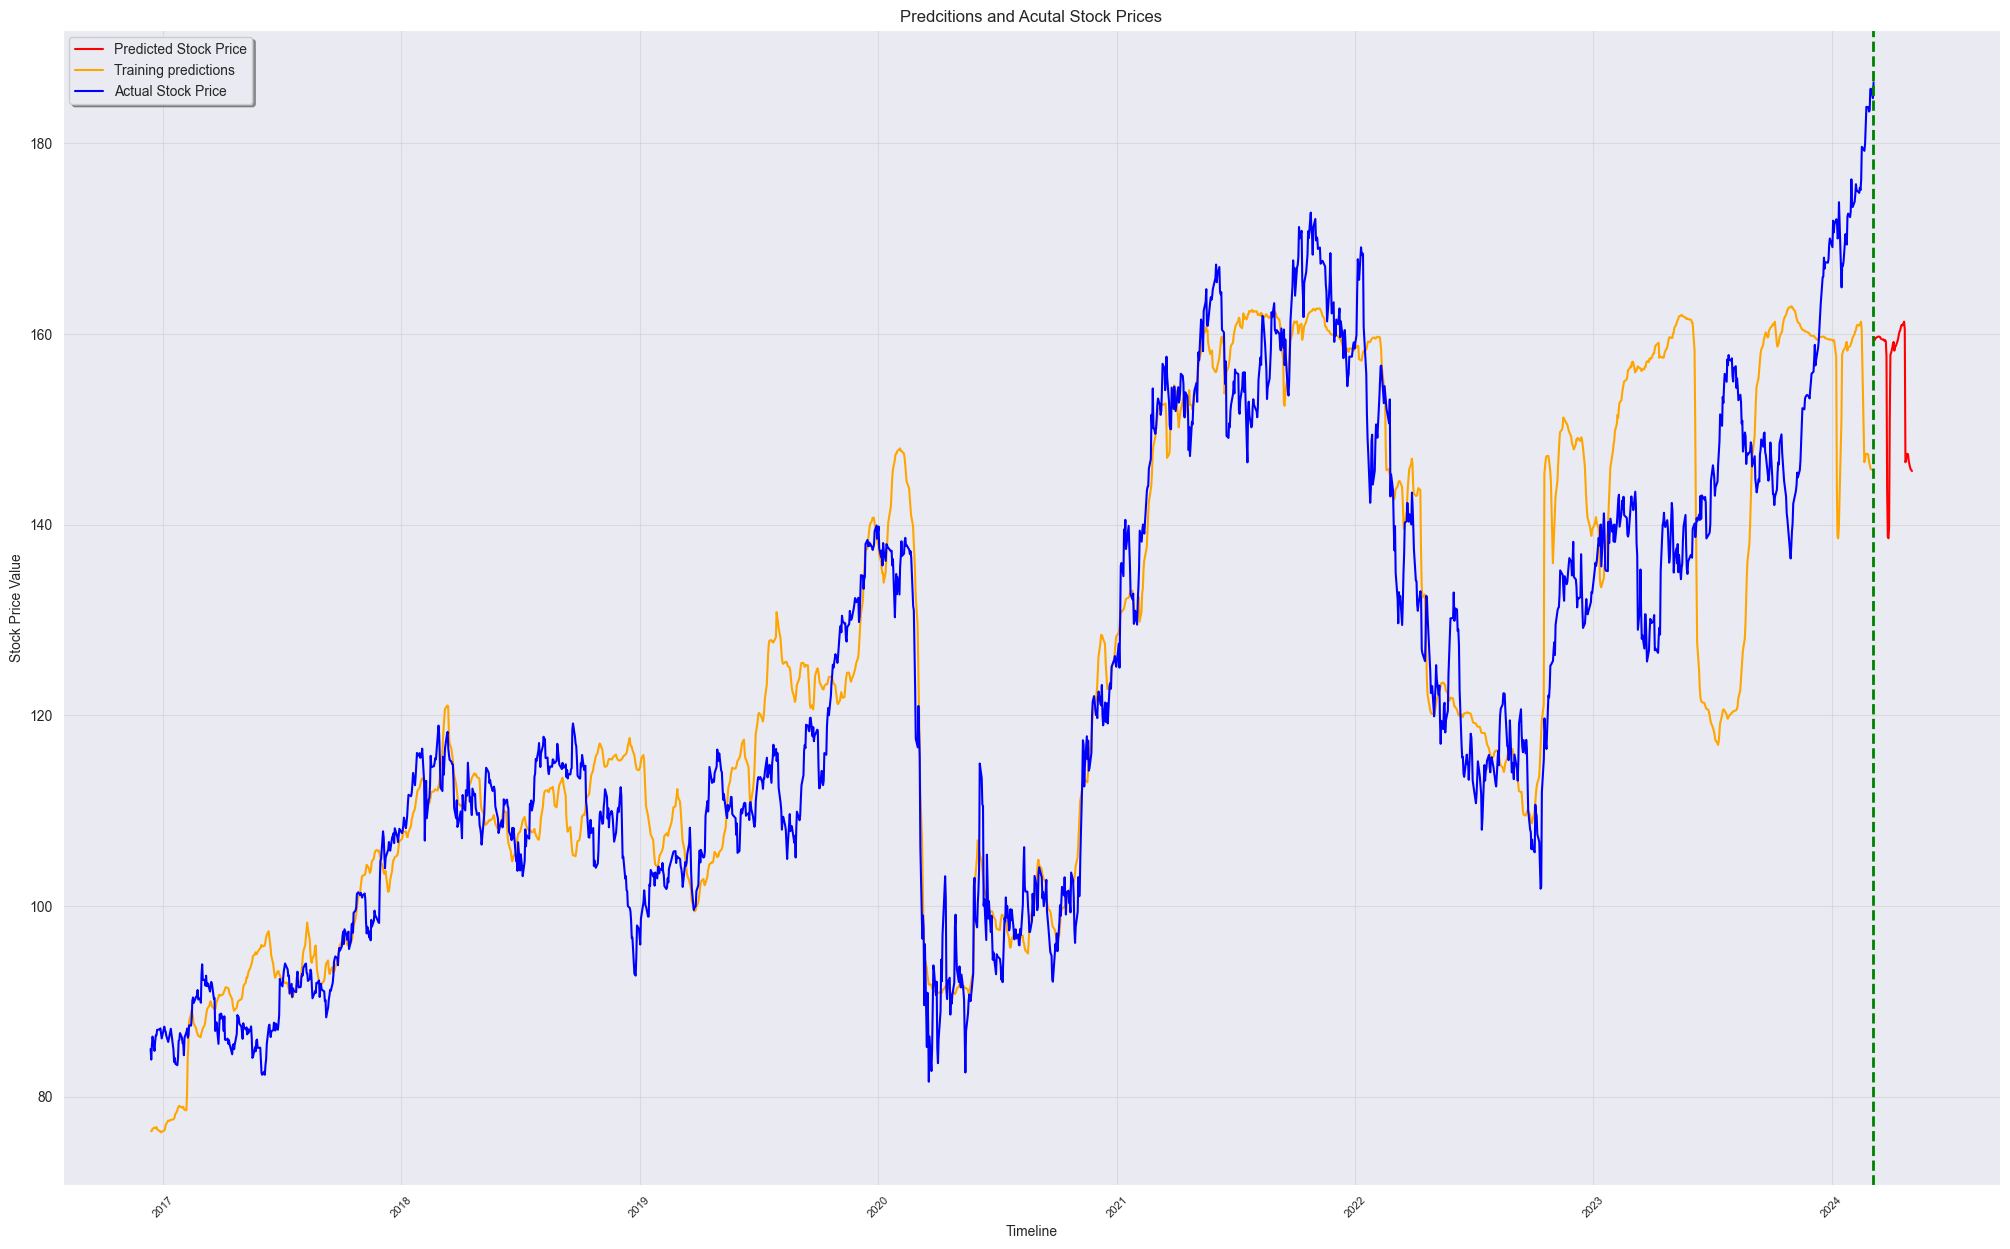

In [15]:
# Set plot size 
mpl.rcParams['figure.figsize'] = 25, 15

# Plot parameters
START_DATE_FOR_PLOTTING = dt.datetime(2016, 12, 13, 0, 0, tzinfo=tz.tzoffset(None, -18000))  #'2016-03-05'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['open'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['open'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['open'], color='b', label='Actual Stock Price')

plt.axvline(x=min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

In [16]:
# Parse training set timestamp for better visualization
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)